# Cat vs. Dog Image Classification Using Deep Learning in Python

**Carter Susi**

**Dec 02, 2025**

**CAP4613**

**Repo**: [https://github.com/cartersusi/susi-ml-bonus](https://github.com/cartersusi/susi-ml-final)

In [1]:
!pip install kagglehub matplotlib torch torchinfo torchvision tqdm scikit-learn seaborn

## Set Config

In [3]:
import os
import shutil

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from PIL import Image, ImageFile

warnings.filterwarnings("ignore", category=UserWarning, module="PIL")
warnings.filterwarnings("ignore", ".*Truncated File Read.*")
ImageFile.LOAD_TRUNCATED_IMAGES = True

cwd = os.getcwd()
home = os.path.expanduser("~")

conf = {
  "models_dir": f"{cwd}/models",
  "kaggle_creds": f"{home}/.kaggle/kaggle.json",
  "model_path": f"/{cwd}/models/cat_dog_cnn_25.pth"
}

def copy_creds(from_path: str, to_path: str) -> bool:
  try:
    os.makedirs(os.path.dirname(conf["kaggle_creds"]), exist_ok=True)
    shutil.copy(from_path, to_path)
    os.chmod(to_path, 0o600)
  except Exception as e:
    print("error copying kaggle credential file", e)

if not os.path.exists(conf["kaggle_creds"]):
  try:
    from google.colab import files
    print("Please upload your 'kaggle.json' credential file\n")
    files.upload()
    copy_creds("kaggle.json", conf["kaggle_creds"])
  except ImportError:
    if not os.path.exists("kaggle.json"):
      raise Exception(f"kaggle.json is not in current directory or {conf['kaggle_creds']}")
    copy_creds("kaggle.json", conf["kaggle_creds"])


try:
  import google.colab

  image_size = (64, 64)
  print(f"In Colab, using image size: '{image_size[0]}x{image_size[1]}px'")
except ImportError:
  vram = torch.cuda.get_device_properties(0).total_memory / (1024**3)
  if vram < 10.0:  # Needs ~8.5 Gb for 256x256
    image_size = (128, 128)
  else:
    image_size = (256, 256)

  print(
    f"Not in Colab with {vram} GB VRAM, default image size: '{image_size[0]}x{image_size[1]}px'"
  )

Please upload your 'kaggle.json' credential file


Saving kaggle.json to kaggle.json
In Colab, using image size: '64x64px'


## Download Cat Vs Dog Dataset

In [4]:
import kagglehub

def _find_image_folder(root_path: str) -> str:
  for dirpath, dirnames, _ in os.walk(root_path):
    if "Cat" in dirnames and "Dog" in dirnames:
      return dirpath
  return ""

dataset_path = _find_image_folder(
  kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
)

print(f"Kaggle Dataset at: {dataset_path}")

Using Colab cache for faster access to the 'kaggle-cat-vs-dog-dataset' dataset.
Kaggle Dataset at: /kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages


## Load Dataset

Dataset samples before processing.



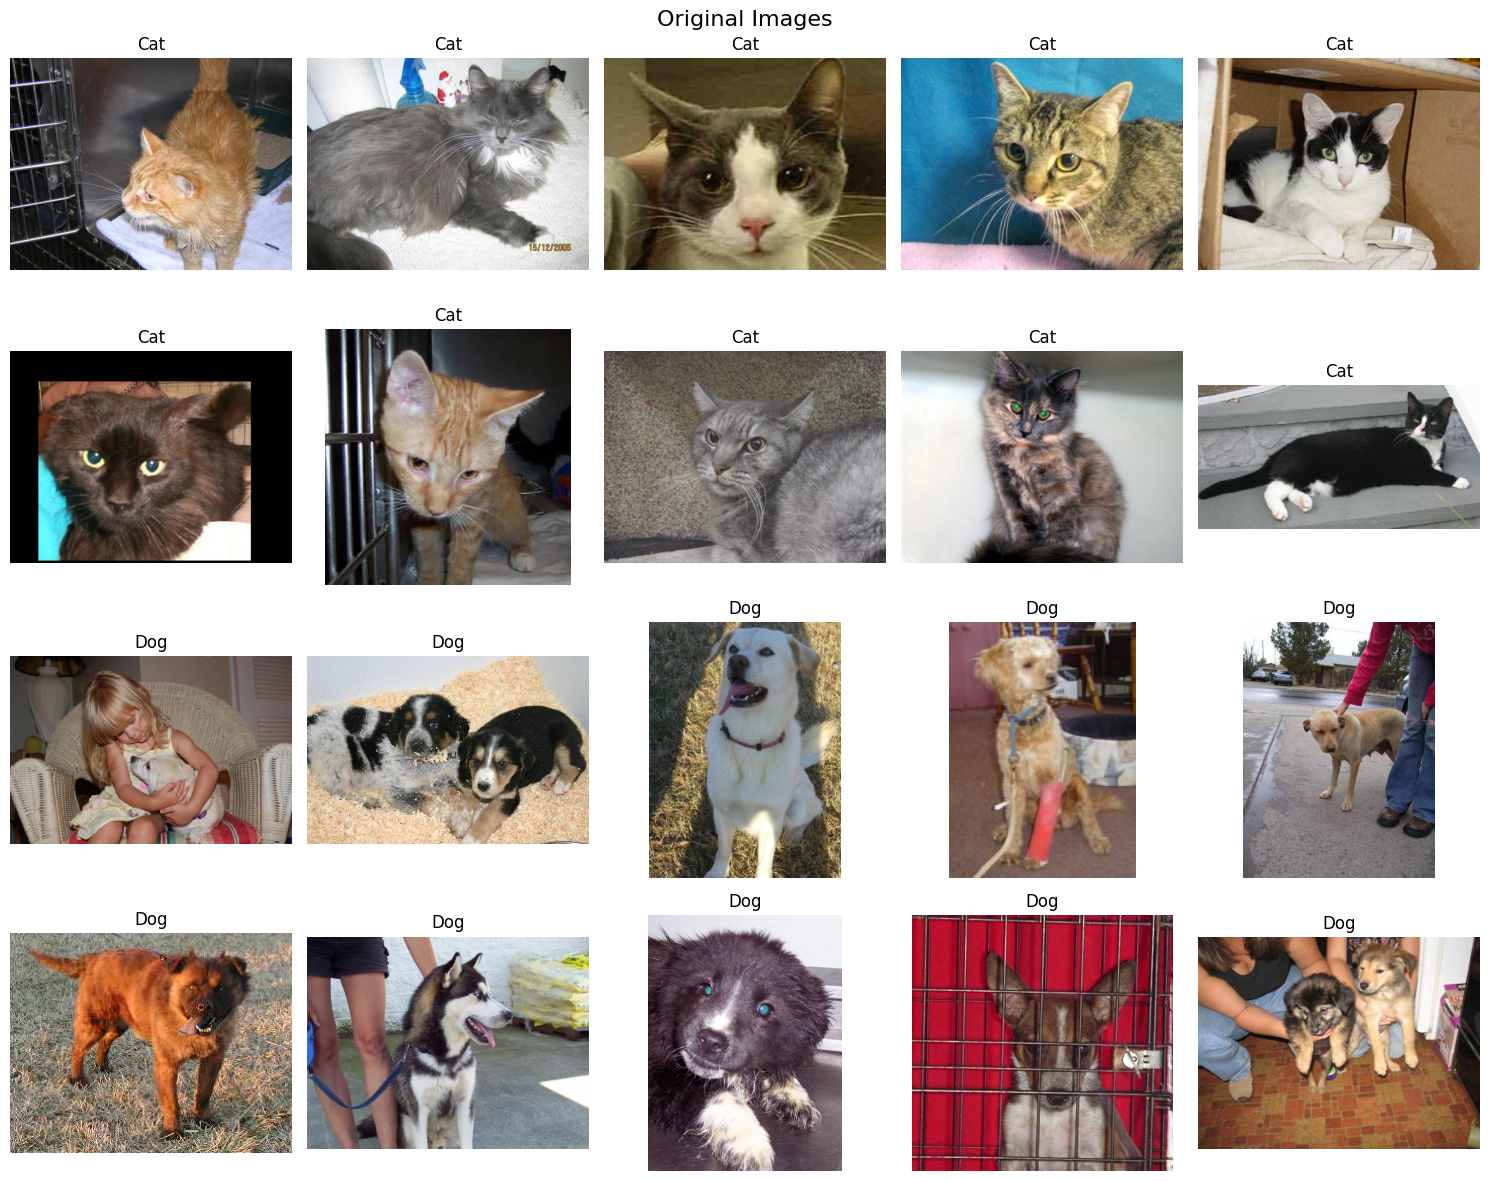


Dataset samples after processing.



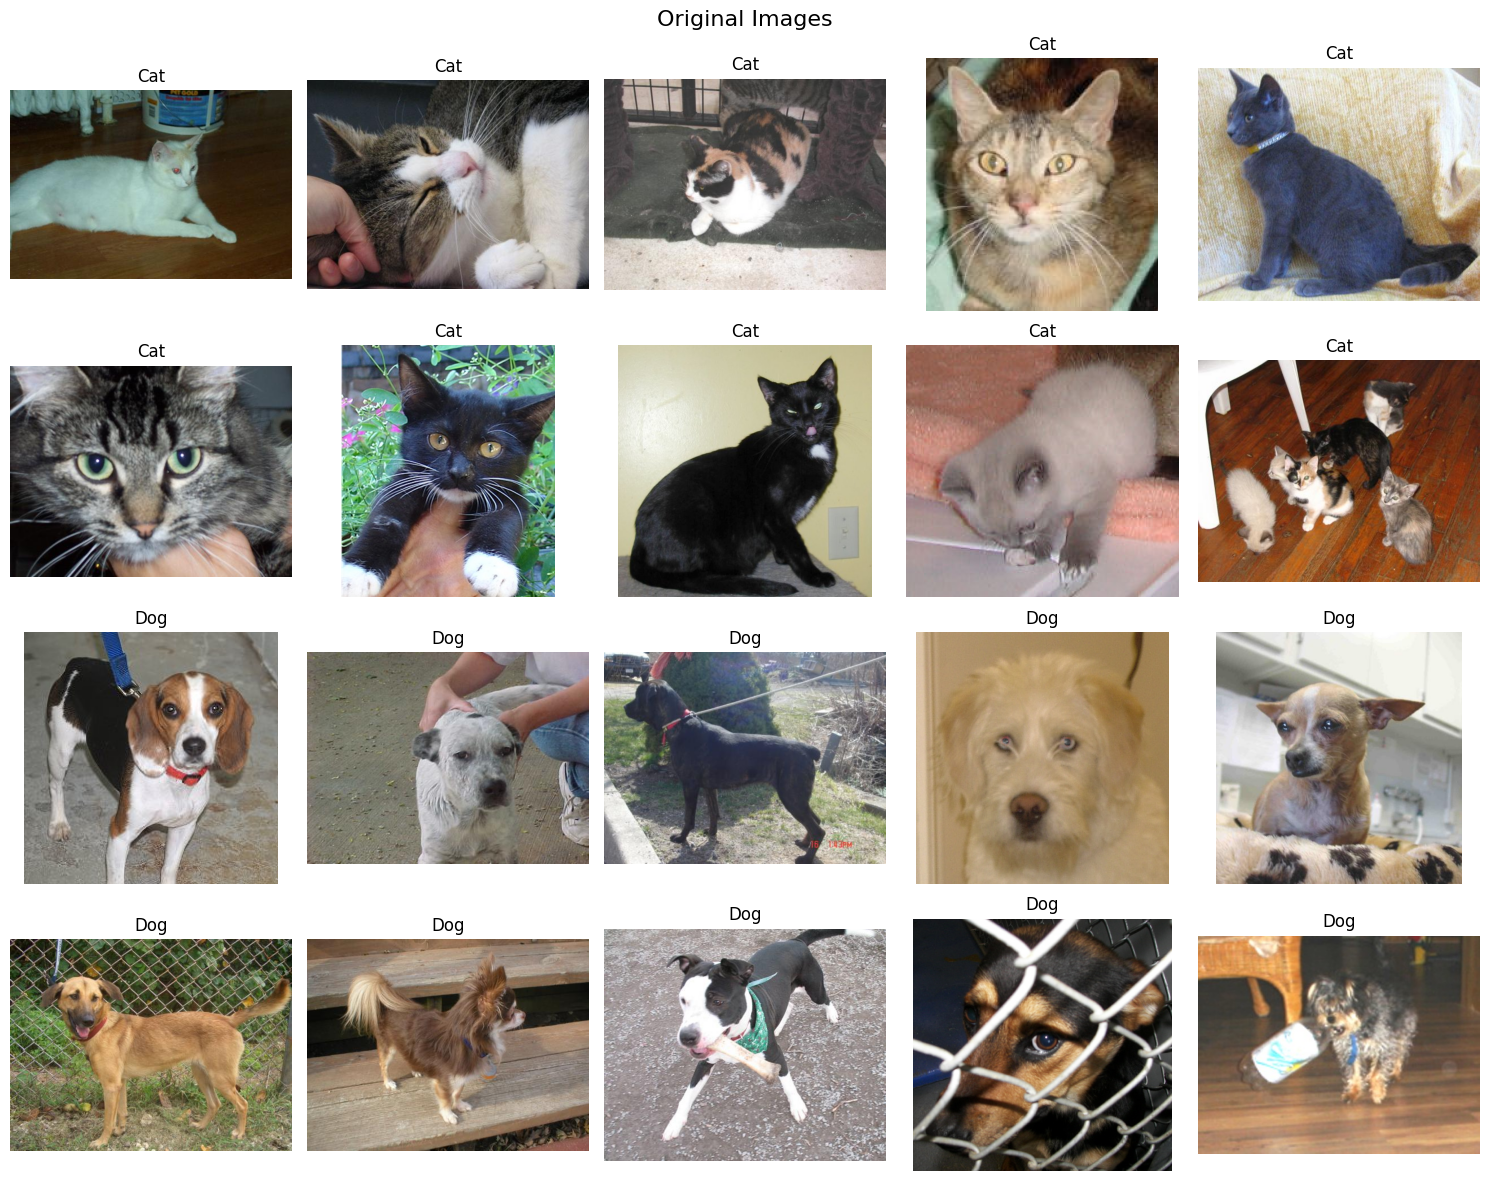

In [7]:
import random

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T


class Dataset:
  def __init__(self, fpath):
    self.data_path = fpath
    self.dataset = datasets.ImageFolder(root=fpath)

    # Training image transforms (70% training)
    self.train_transform = transforms.Compose(
      [
        transforms.Resize(image_size),  # Resize all images to 150×150 pixels
        transforms.RandomHorizontalFlip(),  # Apply basic data augmentation (horizontal flip)
        transforms.RandomRotation(
          15
        ),  # Apply basic data augmentation (rotation)
        transforms.ToTensor(),  # Normalize pixel values to [0, 1] range
        transforms.RandomApply(
          [T.GaussianNoise(mean=0.0, sigma=0.20, clip=True)],
          p=0.5,  # Apply max-noise of 0.20 with 50% probability - from Bonus project
        ),
      ]
    )

    # Validation image transforms (15% validation)
    self.validation_transform = transforms.Compose(
      [
        transforms.Resize(image_size),
        transforms.ToTensor(),
      ]
    )

    # Test image transforms (15% val)
    self.test_transform = self.validation_transform

  @property
  def data_size(self) -> int:
    return len(self.dataset)

  @property
  def train_size(self) -> int:
    return int(0.7 * self.data_size)

  @property
  def validation_size(self) -> int:
    return int(0.15 * self.data_size)

  @property
  def test_size(self) -> int:
    return int(self.data_size - self.train_size - self.validation_size)

  def preprocess(self):
    if not self.dataset:
      raise Exception("Dataset must be loaded before preprocessing.")

    train_start, validation_start, test_start = random_split(
      self.dataset, [self.train_size, self.validation_size, self.test_size]
    )

    self.train_data = Subset(
      datasets.ImageFolder(self.data_path, transform=self.train_transform),
      train_start.indices,
    )
    self.val_data = Subset(
      datasets.ImageFolder(self.data_path, transform=self.validation_transform),
      validation_start.indices,
    )
    self.test_data = Subset(
      datasets.ImageFolder(self.data_path, transform=self.test_transform),
      test_start.indices,
    )

  def show_samples(self, train_data=False):
    cats = [
      i for i, (path, _) in enumerate(self.dataset.samples) if "Cat" in path
    ]
    dogs = [
      i for i, (path, _) in enumerate(self.dataset.samples) if "Dog" in path
    ]

    sample_cats = random.sample(cats, min(10, len(cats)))
    sample_dogs = random.sample(dogs, min(10, len(dogs)))

    title = "Augmented Images" if train_data else "Original Images"
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)

    for idx, ax in enumerate(axes.flat):
      img_idx = sample_cats[idx % 10] if idx < 10 else sample_dogs[idx % 10]
      img, _ = self.dataset[img_idx]

      if train_data:
        img = self.train_transform(img).permute(1, 2, 0).numpy()

      ax.imshow(img)
      ax.set_title("Cat" if idx < 10 else "Dog")
      ax.axis("off")

    plt.tight_layout()
    plt.show()

  def augment(self, datatype: str):
    torch.manual_seed(42)

    if datatype == "train":
      return DataLoader(
        self.train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count()
      )
    else:
      return DataLoader(
        self.val_data, batch_size=32, shuffle=True, num_workers=os.cpu_count()
      )

dataset = Dataset(dataset_path)

print("Dataset samples before processing.\n")
dataset.show_samples()

dataset.preprocess()

print("\nDataset samples after processing.\n")
dataset.show_samples()


## Create Model

In [8]:
import torch.nn as nn
import torchinfo

class CatDogCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_layer_1 = nn.Sequential(
      nn.Conv2d(3, 64, 3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2),
    )

    self.conv_layer_2 = nn.Sequential(
      nn.Conv2d(64, 512, 3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(2),
    )

    self.conv_layer_3 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(512),
      nn.MaxPool2d(2),
    )

    self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))

    self.classifier = nn.Sequential(
      nn.Flatten(), nn.Linear(in_features=512 * 2 * 2, out_features=2)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.adaptive_pool(x)
    x = self.classifier(x)
    return x

  def summary(self) -> None:
    torchinfo.summary(self, input_size=[1, 3, image_size[0], image_size[1]])

model = CatDogCNN()
model.summary()
model.to(device)


CatDogCNN(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(2, 2))
  (classifier): Sequential(
    (0

## Train Model

In [10]:
from timeit import default_timer as timer
from typing import Any, Literal, overload

from tqdm import tqdm

train_dataloader_augmented = dataset.augment("train")
val_dataloader_augmented = dataset.augment("val")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

def train() -> dict[str, list[Any]]:
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  os.makedirs(conf["models_dir"], exist_ok=True)

  start_time = timer()

  model_results = _train(epochs=25)

  end_time = timer()
  print(f"Total training time: {end_time - start_time:.3f} seconds")

  return model_results


def _train(epochs: int = 25) -> dict[str, list[Any]]:
  results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = _train_step()

    val_loss, val_acc = _val_step(return_preds=False)

    tqdm.write(
      f"Epoch: {epoch + 1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"val_loss: {val_loss:.4f} | "
      f"val_acc: {val_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

    torch.save(
      model.state_dict(), os.path.join(conf["models_dir"], f"cat_dog_cnn_{epoch + 1}.pth")
    )

  return results


def _train_step() -> tuple[float, float]:
  model.train()

  train_loss, train_acc = 0, 0
  for _, (X, y) in enumerate(train_dataloader_augmented):
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate  and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(train_dataloader_augmented)
  train_acc = train_acc / len(train_dataloader_augmented)
  return train_loss, train_acc


@overload
def _val_step(return_preds: Literal[False] = False) -> tuple[float, float]: ...
@overload
def _val_step(return_preds: Literal[True]) -> tuple[float, float, list[int], list[int]]: ...
def _val_step(return_preds: bool = False) -> tuple[float, float] | tuple[float, float, list[int], list[int]]:
  model.eval()
  val_loss, val_acc = 0, 0
  all_preds, all_labels = [], []

  with torch.inference_mode():
    for _, (X, y) in enumerate(val_dataloader_augmented):
      X, y = X.to(device), y.to(device)
      val_pred_logits = model(X)
      loss = loss_fn(val_pred_logits, y)
      val_loss += loss.item()
      val_pred_labels = val_pred_logits.argmax(dim=1)
      val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

      if return_preds:
        all_preds.extend(val_pred_labels.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

  val_loss = val_loss / len(val_dataloader_augmented)
  val_acc = val_acc / len(val_dataloader_augmented)

  if return_preds:
    return val_loss, val_acc, all_preds, all_labels
  return val_loss, val_acc


res = train()

  4%|▍         | 1/25 [01:25<34:08, 85.35s/it]

Epoch: 1 | train_loss: 0.7326 | train_acc: 0.5789 | val_loss: 0.6514 | val_acc: 0.6345


  8%|▊         | 2/25 [02:19<25:42, 67.05s/it]

Epoch: 2 | train_loss: 0.6725 | train_acc: 0.6281 | val_loss: 0.6289 | val_acc: 0.6514


 12%|█▏        | 3/25 [03:11<22:03, 60.16s/it]

Epoch: 3 | train_loss: 0.6292 | train_acc: 0.6673 | val_loss: 0.6233 | val_acc: 0.6468


 16%|█▌        | 4/25 [04:04<20:04, 57.34s/it]

Epoch: 4 | train_loss: 0.5774 | train_acc: 0.7037 | val_loss: 0.5162 | val_acc: 0.7481


 20%|██        | 5/25 [04:56<18:28, 55.44s/it]

Epoch: 5 | train_loss: 0.5355 | train_acc: 0.7386 | val_loss: 0.5205 | val_acc: 0.7291


 24%|██▍       | 6/25 [05:50<17:22, 54.84s/it]

Epoch: 6 | train_loss: 0.4898 | train_acc: 0.7661 | val_loss: 0.4675 | val_acc: 0.7734


 28%|██▊       | 7/25 [06:42<16:13, 54.10s/it]

Epoch: 7 | train_loss: 0.4339 | train_acc: 0.7998 | val_loss: 0.6542 | val_acc: 0.7194


 32%|███▏      | 8/25 [07:34<15:08, 53.43s/it]

Epoch: 8 | train_loss: 0.3975 | train_acc: 0.8211 | val_loss: 0.4852 | val_acc: 0.7732


 36%|███▌      | 9/25 [08:27<14:09, 53.10s/it]

Epoch: 9 | train_loss: 0.3778 | train_acc: 0.8355 | val_loss: 0.4252 | val_acc: 0.8050


 40%|████      | 10/25 [09:21<13:21, 53.43s/it]

Epoch: 10 | train_loss: 0.3582 | train_acc: 0.8416 | val_loss: 0.3231 | val_acc: 0.8597


 44%|████▍     | 11/25 [10:14<12:27, 53.42s/it]

Epoch: 11 | train_loss: 0.3431 | train_acc: 0.8492 | val_loss: 0.3378 | val_acc: 0.8469


 48%|████▊     | 12/25 [11:07<11:29, 53.06s/it]

Epoch: 12 | train_loss: 0.3332 | train_acc: 0.8552 | val_loss: 0.3332 | val_acc: 0.8474


 52%|█████▏    | 13/25 [11:59<10:33, 52.79s/it]

Epoch: 13 | train_loss: 0.3082 | train_acc: 0.8660 | val_loss: 0.2907 | val_acc: 0.8646


 56%|█████▌    | 14/25 [12:52<09:41, 52.84s/it]

Epoch: 14 | train_loss: 0.3001 | train_acc: 0.8723 | val_loss: 0.3094 | val_acc: 0.8654


 60%|██████    | 15/25 [13:51<09:07, 54.75s/it]

Epoch: 15 | train_loss: 0.2901 | train_acc: 0.8757 | val_loss: 0.2750 | val_acc: 0.8811


 64%|██████▍   | 16/25 [14:44<08:09, 54.39s/it]

Epoch: 16 | train_loss: 0.2735 | train_acc: 0.8820 | val_loss: 0.2838 | val_acc: 0.8712


 68%|██████▊   | 17/25 [15:37<07:11, 53.94s/it]

Epoch: 17 | train_loss: 0.2694 | train_acc: 0.8843 | val_loss: 0.2853 | val_acc: 0.8747


 72%|███████▏  | 18/25 [16:30<06:14, 53.51s/it]

Epoch: 18 | train_loss: 0.2656 | train_acc: 0.8877 | val_loss: 0.2536 | val_acc: 0.8867


 76%|███████▌  | 19/25 [17:36<05:43, 57.24s/it]

Epoch: 19 | train_loss: 0.2513 | train_acc: 0.8933 | val_loss: 0.2686 | val_acc: 0.8814


 80%|████████  | 20/25 [18:46<05:05, 61.04s/it]

Epoch: 20 | train_loss: 0.2488 | train_acc: 0.8925 | val_loss: 0.3265 | val_acc: 0.8387


 84%|████████▍ | 21/25 [19:54<04:13, 63.35s/it]

Epoch: 21 | train_loss: 0.2398 | train_acc: 0.9003 | val_loss: 0.2825 | val_acc: 0.8726


 88%|████████▊ | 22/25 [20:56<03:08, 62.96s/it]

Epoch: 22 | train_loss: 0.2239 | train_acc: 0.9060 | val_loss: 0.2784 | val_acc: 0.8784


 92%|█████████▏| 23/25 [21:51<02:00, 60.36s/it]

Epoch: 23 | train_loss: 0.2197 | train_acc: 0.9094 | val_loss: 0.3787 | val_acc: 0.8285


 96%|█████████▌| 24/25 [22:43<00:57, 57.84s/it]

Epoch: 24 | train_loss: 0.2084 | train_acc: 0.9114 | val_loss: 0.2516 | val_acc: 0.8881


100%|██████████| 25/25 [23:35<00:00, 56.61s/it]

Epoch: 25 | train_loss: 0.2022 | train_acc: 0.9151 | val_loss: 0.2816 | val_acc: 0.8728
Total training time: 1415.255 seconds


## Visualizations

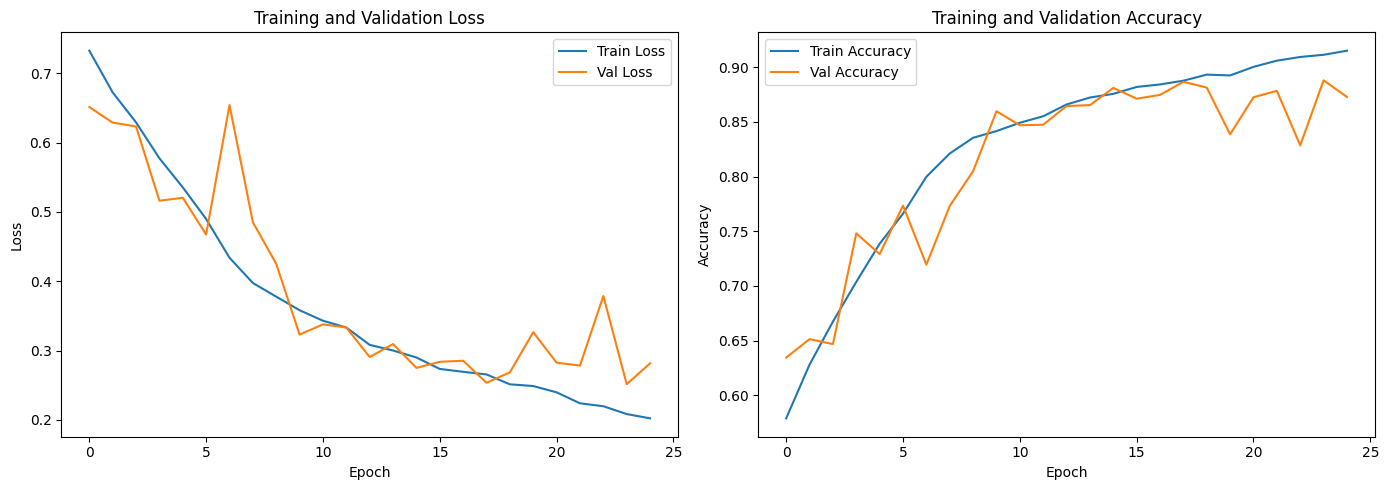


Final Validation Accuracy: 0.8728


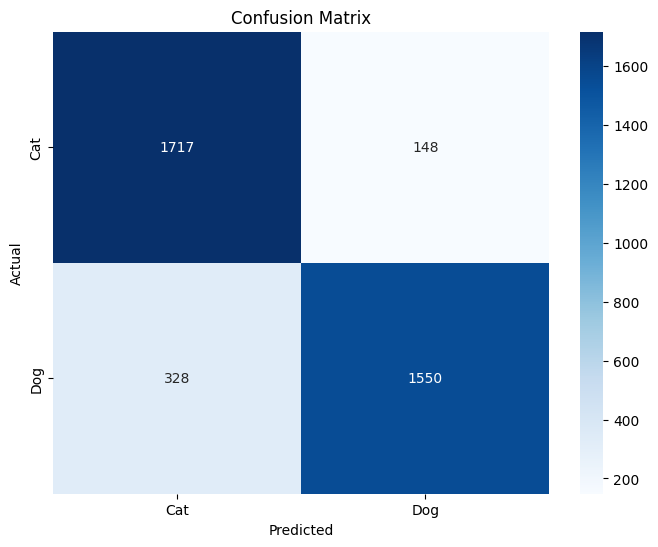

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(res['train_loss'], label='Train Loss')
ax1.plot(res['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(res['train_acc'], label='Train Accuracy')
ax2.plot(res['val_acc'], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()

model.eval()
_, val_acc, val_preds, val_labels = _val_step(return_preds=True)

print(f'\nFinal Validation Accuracy: {val_acc:.4f}')


cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Saving b54472aacb5d6ee99f29c6170fa6725e.JPG to b54472aacb5d6ee99f29c6170fa6725e (2).JPG


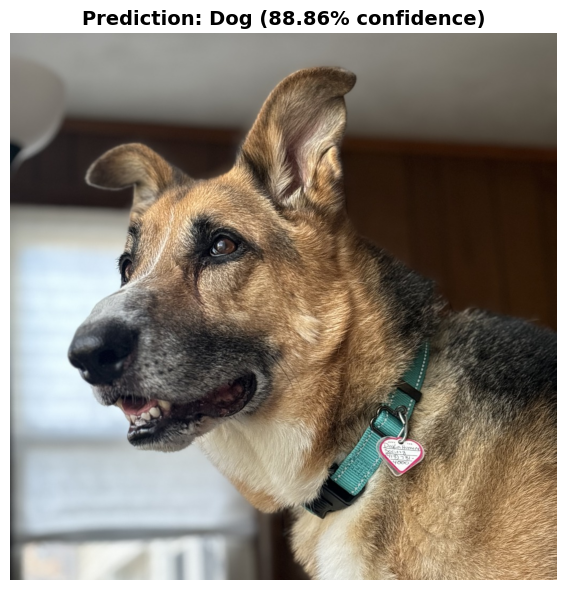

In [17]:
#@title Model Inference - Upload Image

model.eval()

transform = transforms.Compose(
  [
    transforms.Resize(image_size),
    transforms.ToTensor(),
  ]
)

uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0).to(device)

with torch.inference_mode():
  logits = model(image_tensor)
  probs = torch.softmax(logits, dim=1)
  predicted_class = torch.argmax(probs, dim=1).item()

class_names = ["Cat", "Dog"]

label = class_names[predicted_class]

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {class_names[predicted_class]} ({probs[0, predicted_class].item():.2%} confidence)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()